In [1]:
import sys
sys.path.append('../')
from xd import *
import numpy as np
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
HFactor = HF(100, 10)

from systematics_module.corr import angular_correlation_poisson, angular_correlation

In [2]:
#root = '/n/des/lee.5922/data/cmass_cat/dr12_multidark_patchy_mocks/'
basedir = '../data_txt/cmass/'
#cmass_ngc = esutil.io.read(path+'cmass-dr12v4-N-Reid-full.dat.fits')
#cmass_sgc = esutil.io.read(path+'cmass-dr12v4-S-Reid-full.dat.fits')
#cmass_ngc = cmass_ngc[(cmass_ngc['Z'] > 0.43) & (cmass_ngc['Z'] < 0.7)]

cmasspath = '/n/des/lee.5922/data/cmass_cat/'
#cmass_ngc = esutil.io.read(cmasspath+'galaxy_DR12v5_CMASS_North.fits.gz')
#rand_ngc = esutil.io.read(cmasspath+'random0_DR12v5_CMASS_North.fits.gz')

cmass_sgc = esutil.io.read(cmasspath+'galaxy_DR12v5_CMASS_South.fits.gz')
rand_sgc = esutil.io.read(cmasspath+'random0_DR12v5_CMASS_South.fits.gz')
                          # ,cmasspath+'random1_DR12v5_CMASS_South.fits.gz'
                          #, combine=False)
#cmass_ngc = esutil.io.read(cmasspath+'cmass-dr12v4-N-Reid-full.dat.fits')
#cmass_sgc_reid = esutil.io.read(cmasspath+'cmass-dr12v4-S-Reid-full.dat.fits')

cmass_weight = cmass_sgc['WEIGHT_SYSTOT']*(cmass_sgc['WEIGHT_CP']+cmass_sgc['WEIGHT_NOZ']-1.)
cmass_sgc = appendColumn(cat = cmass_sgc, name='WEIGHT', value=cmass_weight)
rand_sgc = appendColumn(cat = rand_sgc, name='WEIGHT_RAND', value=np.ones(rand_sgc['WEIGHT_FKP'].size))


In [8]:
def angular_correlation_jkd( data, rand, weight_data=None, weight_rand = None, 
                            nbins = 20, min_sep = 2.5/60, max_sep = 250/60., dir='./', suffix='',
                            Ns = 12, Nd = 4, out=False ):
    
    
    
    if 'JKindex' not in data.dtype.names: 
        
        print 'Assigning JKindex...', Ns
        from utils import construct_jk_catalog
        
        jfile = 'jkregion.txt'
        data = construct_jk_catalog( data, njack = Ns, root=dir, jtype = 'generate', 
                                 jfile = jfile, suffix = '' , retind = True)
        rand = construct_jk_catalog( rand, njack = Ns, root=dir, jtype = 'read', 
                                 jfile = jfile, suffix = '' , retind = True)
        
    
    _dir = dir + '/jkd/'
    os.system('mkdir '+_dir)
    # A Python program to print all combinations  
    # of given length with duplicates in input 
    from itertools import combinations 

    # Get all combinations of [1, 1, 3] 
    # and length 2 
    comb = combinations(range(Ns), Nd) 
    comb = list(comb)
    Njk = len(comb)
    
    print 'Ns=',Ns,
    print ', Nd=',Nd,
    print ', Total JK samples=', Njk

    xi_i_list = []
    
    for i, jkind in enumerate(comb):
        
        _suffix = '_'+suffix + '_JK-'+str(i)+'_'+str(Njk)
        fn = _dir+'/acf_auto_poisson'+_suffix+'.txt'
        if os.path.exists(fn) : 
            print 'calling stored data: ', fn
            theta, xi_i, _ = np.genfromtxt(fn, unpack=True)
            xi_i_list.append(xi_i)
            
        else : 
        
            mask = np.ones(data.size, dtype=bool)
            rand_mask = np.ones(rand.size, dtype=bool)
            for jkind_i in jkind : 
                mask *= (data['JKindex'] != jkind_i)
                rand_mask *= (rand['JKindex'] != jkind_i)
            #data_i = data[mask]
        
            theta, xi_i, _ = \
            angular_correlation_poisson(data[mask], rand[rand_mask], weight_data = weight_data, weight_rand = weight_rand, 
            nbins = nbins, min_sep = min_sep, max_sep = max_sep, dir = _dir, suffix=_suffix, retout = True)
            
            xi_i_list.append(xi_i)
    
    
    xi_i_list = np.array(xi_i_list)
    #xi_i_list = xi_i_list.reshape(Njk, theta.size)
    xi_mean = np.mean( xi_i_list, axis=0)
    
    
    norm = (Ns-Nd)*1./(Nd * Njk)
    xi_cov = np.zeros((theta.size, theta.size))
    for i in range(theta.size):
        for j in range(theta.size):
            xi_cov[i][j] = norm* np.sum( (xi_i_list[:, i] - xi_mean[i]) * (xi_i_list[:,j]-xi_mean[j] ))
            
    # hartlap correction
    xijkerr = np.sqrt(xi_cov.diagonal())
    
    
    #return xi_i_list, xi_mean
    
    _suffix2 = suffix + '_JK-'+str(Ns)+'-'+str(Nd)+'-'+str(Njk)
    filename = dir+'/acf_auto_jkd_'+_suffix2+'.txt'
    header = 'theta, wtheta, jkderr'
    DAT = np.column_stack((theta, xi_mean, xijkerr ))
    np.savetxt( filename, DAT, delimiter=' ', header=header )
    np.savetxt(dir+'/acf_auto_jkd_'+_suffix2+'.cov', xi_cov, header=''+str(theta))
    #np.savetxt(dir+'/acf_auto'+suffix+'.jk_corr', xi_dat, header='r  jksamples')
    print "saving data file to : ",filename
    
    if out is True : return DAT
    

In [190]:
#angular_correlation_jkd( cmass_sgc, rand_sgc, weight_data=True, weight_rand = True, 
#                            nbins = 10, dir=basedir, suffix='galaxy_DR12v5_CMASS_South', Ns = 12, Nd = 4 )

Ns= 12 , Nd= 4 , Total JK samples= 495
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-0_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-1_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-2_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-3_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-4_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-5_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-6_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-7_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-8_495.tx

calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-110_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-111_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-112_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-113_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-114_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-115_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-116_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-117_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-118_495.txt
calling stored data

calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-219_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-220_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-221_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-222_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-223_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-224_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-225_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-226_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-227_495.txt
calling stored data

calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-329_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-330_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-331_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-332_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-333_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-334_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-335_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-336_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-337_495.txt
calling stored data

calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-438_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-439_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-440_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-441_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-442_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-443_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-444_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-445_495.txt
calling stored data:  ../data_txt/jk_delete_d//jkd//acf_auto_poissongalaxy_DR12v5_CMASS_South_JK-446_495.txt
calling stored data

In [6]:
from utils import construct_jk_catalog

basedir2 = '../data_txt/jk_delete_d_12_6/'
os.system('mkdir '+basedir2)


cmass_sgc = construct_jk_catalog( cmass_sgc, njack = 12, root=basedir2, jtype = 'generate', 
                                 jfile = 'jkregion_12.txt', suffix = '' , retind = True)
rand_sgc = construct_jk_catalog( rand_sgc, njack = 12, root=basedir2, jtype = 'read', 
                                 jfile = 'jkregion_12.txt', suffix = '' , retind = True)


X (960, 2)  centers (12, 2)  tol=1e-05  maxiter=200
39 iterations  cluster sizes: [ 85  79  76  62  65  68 121  76  94  94  64  76]
X (230831, 2)  centers (12, 2)  tol=1e-05  maxiter=200
19 iterations  cluster sizes: [19891 20965 18453 17146 19072 17952 22228 19384 20716 20052 17256 17716]
read stored jfile : ../data_txt/jk_delete_d_12_6/jkregion_12.txt


In [9]:
angular_correlation_jkd( cmass_sgc, rand_sgc, weight_data=True, weight_rand = True, 
                            nbins = 10, dir=basedir2, suffix='galaxy_DR12v5_CMASS_South', Ns = 12, Nd = 6 )

Ns= 12 , Nd= 6 , Total JK samples= 924
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-0_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-1_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-2_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-3_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-4_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-5_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-6_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-7_924.txt
saving data file to :  ../data_txt/jk_delete_d_12

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-71_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-72_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-73_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-74_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-75_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-76_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-77_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-78_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galax

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-142_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-143_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-144_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-145_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-146_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-147_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-148_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-149_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-213_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-214_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-215_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-216_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-217_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-218_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-219_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-220_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-284_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-285_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-286_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-287_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-288_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-289_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-290_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-291_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-355_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-356_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-357_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-358_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-359_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-360_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-361_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-362_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-426_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-427_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-428_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-429_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-430_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-431_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-432_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-433_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-497_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-498_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-499_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-500_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-501_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-502_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-503_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-504_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-568_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-569_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-570_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-571_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-572_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-573_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-574_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-575_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-639_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-640_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-641_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-642_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-643_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-644_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-645_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-646_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-710_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-711_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-712_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-713_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-714_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-715_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-716_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-717_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-781_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-782_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-783_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-784_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-785_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-786_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-787_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-788_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-852_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-853_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-854_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-855_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-856_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-857_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-858_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-859_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poiss

saving data file to :  ../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-923_924.txt
saving data file to :  ../data_txt/jk_delete_d_12_6//acf_auto_jkd_galaxy_DR12v5_CMASS_South_JK-12-6-924.txt


In [10]:
theta, xijk, xijkerr = np.genfromtxt('../data_txt/jk_delete_d_12_6//acf_auto_jkd_galaxy_DR12v5_CMASS_South_JK-12-6-924.txt', unpack=True)

(0.0001, 0.28804718485500247)

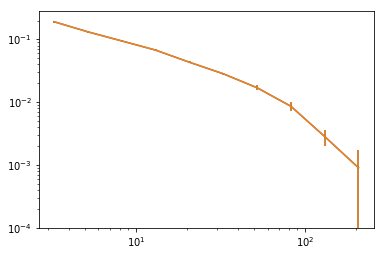

In [22]:



#meanr = np.logspace(np.log10(2.5), np.log10(250), 10)
fig, ax = plt.subplots()
#ax.loglog(meanr, ximean)
#ax.loglog(meanr, xi_data[0,:])

xijklist = []
for i in range(924):
    fn = '../data_txt/jk_delete_d_12_6//jkd//acf_auto_poisson_galaxy_DR12v5_CMASS_South_JK-{}_924.txt'.format(i)
    theta, xijk_i, _ = np.genfromtxt(fn, unpack=True)
    xijklist.append(xijk_i)
    #ax.plot(theta*60, xijk_i, lw=0.5, alpha = 0.1, color='grey')
    
xijklist=np.array(xijklist)
xijkmean = np.mean(xijklist, axis=0)
ax.errorbar(theta*60, xijk, yerr= xijkerr )
ax.errorbar(theta*60, xijkmean, yerr= xijkerr )
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim(1e-04,)

In [23]:
xijkerr

array([0.00536515, 0.0043083 , 0.00258513, 0.00194203, 0.00155251,
       0.0013303 , 0.00154205, 0.00130686, 0.0008015 , 0.00081343])